## Preparing dataframe for ML Modelling

### Setup -> import required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from timeit import default_timer as timer

from models.flight_duration import *
from models.get_countries import *
from models.timesplit import *
from models.get_geo_info import *
from models.airport_dummies import *
from models.code_to_get_dummies import *
from models.eval_metrics import *
from models.error_plot import *

RSEED =10

In [2]:
# importing airports database for location and timezone
# pip install airportsdata

import airportsdata

airports = airportsdata.load()  # key is ICAO code, the default
df_1 = pd.DataFrame(airports).transpose()

df_1.sample(3)

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
EDAM,EDAM,,Merseburg Airport,Merseburg,Saxony-Anhalt,DE,341.0,51.363609,11.948333,Europe/Berlin
KTTS,KTTS,,Nasa Shuttle Landing Facility Airport,Titusville,Florida,US,10.0,28.615,-80.694504,America/New_York
HKKL,HKKL,ILU,Kilaguni Airport,Kilaguni,Taita-Taveta,KE,2750.0,-2.91061,38.065201,Africa/Nairobi


### Importing Training data

In [3]:
# importing Training data
df = pd.read_csv('data/Train.csv')

df.head(3)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0


In [4]:
# importing Airports database for 'IATA'

airports = airportsdata.load('IATA')
airports_df = pd.DataFrame(airports).transpose()

airports_df.head(3)

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
ICY,19AK,ICY,Icy Bay Airport,Icy Bay,Alaska,US,50.0,59.969002,-141.662003,America/Anchorage
HGZ,2AK6,HGZ,Hog River Airport,Hogatza,Alaska,US,534.0,66.216103,-155.669006,America/Anchorage
BYW,38WA,BYW,Blakely Island Airport,Blakely Island,Washington,US,66.0,48.578999,-122.825996,America/Los_Angeles


---
### Feature Engineering
<br>

**STEP-1**
- Converting `STD` (scheduled time of departure) and `STA` (scheduled time of arrival) to date time formate <br>

**STEP-2**
- Extract flight duration from `STD` and `STA` columns
- AM/PM flight timings are extracted from `STD` and `STA` columns <br>

**STEP-3**
- Extract year, month and weekday from `DATOP` (Date of flight) column <br>

**STEP-4**
- Extracting country name from Airports Database
- Catagories International and National flight based on Departure and Arrival airports <br>

**STEP-5**
- Flight ID is extracted from `FLTID` column
- Aircraft name is extracted from `AC`column <br>

**STEP-6**
- Create dummies for `month`, `weekday`,`STATUS`, `National_International_Flight`, `AM_PM_flight`, `flight_ID` and `aircraft_name` columns <br>

**STEP-7**
- Dropping `ID`, `DATOP`, `STD`, `STA`, `FLTID`, `AC`, `arr_country`, `dep_country`, `dep_hour`, `arr_hour`, `AC`, `month`, `weekday`,`STATUS`, `National_International_Flight`, `AM_PM_flight`, `flight_ID` and `aircraft_name` columns

<br>

-----------------------------------------------------------------------------------------------------------------------

In [5]:
# Feature engineering

# flight duration in minutes
df = flight_duration(df,"scheduled_time_dep", "scheduled_time_arr")

# Country names are included
df = get_geo_info(df,airports_df)

# Convert 'dep_date' datatype and extract months, year and days
df_1 = timeSplit(df,"dep_date",df.ID)
df = df_1.merge(df, on="ID")

# create dummies 
df = code_to_get_dummies(df)

In [6]:
# Random 3 rows from dataframe

df.sample(3)

,year,DEPSTN,ARRSTN,target,flight_duration,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,aircraft_name_332,aircraft_name_343,aircraft_name_345,aircraft_name_733,aircraft_name_734,aircraft_name_736,aircraft_name_738,aircraft_name_AT7,aircraft_name_CR9,aircraft_name_M87
47216,2017,LYS,TUN,30.0,115.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
53613,2017,HAM,NBE,85.0,175.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
70406,2017,TUN,CMN,520.0,160.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Criteria for filter
- Extract dataframe for target value greater than 0
- percentage of delays for less than 1 day (99.85 %)
- Exclude data for delays of more than 1 day

In [7]:
# extract dataframe for target greater than 0

df_delay = df[df['target']!=0]

In [8]:
# percentage of delay for more less than 1 day

round(len(df_delay[df_delay['target']<=1440]) / len(df_delay) *100, 2)

99.85

Text(0.5, 0, 'Delay in mins')

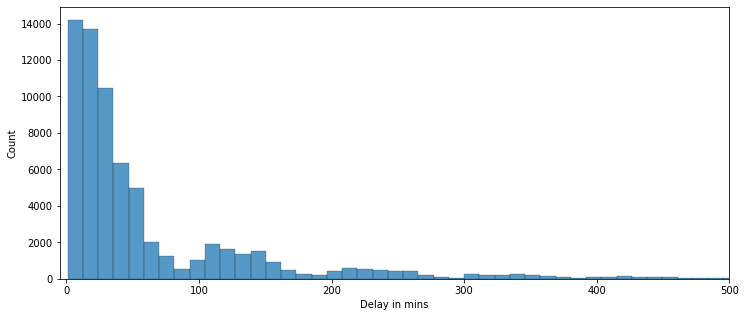

In [9]:
plt.subplots(figsize=(12,5))

sns.histplot(df_delay.target, bins=300)

plt.xlim(-5, 500)
plt.xlabel('Delay in mins')

In [10]:
df = df[df['target']<=1440]

### Bins for Departure station

- Based on value count bins has been created

In [11]:
df.DEPSTN.value_counts()

TUN    42506
DJE    10240
ORY     6752
MIR     5242
MRS     2844
       ...  
ADB        1
SKG        1
OTP        1
KBP        1
CTA        1
Name: DEPSTN, Length: 132, dtype: int64

In [12]:
# Bins list based on value counts

bns=[200,1000,2000,10000,15000,30000,50000]

# creating bins based on 'DEPSN' column
t, bins = airports_dummies(df,bns,"DEPSTN")

# Dropping 'DEPSN' and 'ARRSTN' columns
df_bin = t.drop(columns=['DEPSTN', 'ARRSTN'], axis=1)

# renaming bin columns
df = df_bin.rename(columns={'val_(1000, 2000]': 'bin1', 'val_(2000, 10000]': 'bin2', 'val_(10000, 15000]': 'bin3',
                     'val_(15000, 30000]': 'bin4', 'val_(30000, 50000]': 'bin5'})

In [13]:
df.head(3)

,year,target,flight_duration,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Flight_status_DEL,...,aircraft_name_736,aircraft_name_738,aircraft_name_AT7,aircraft_name_CR9,aircraft_name_M87,bin1,bin2,bin3,bin4,bin5
0,2016,260.0,145.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2016,0.0,145.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2016,0.0,145.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
#df_op = df_bin.to_csv('DNN_df1.csv', index=False)

## Train-Test split

In [15]:
# from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

### Baseline Model using Dummy Regressor

In [16]:
# from sklearn.dummy import DummyRegressor

dummy_mean = DummyRegressor(strategy = 'mean')

# Fit model to training data
dummy_mean.fit(X_train, y_train)

# Make predictions on train set
y_train_pred = dummy_mean.predict(X_train)

# Make predictions on test set
y_test_pred = dummy_mean.predict(X_test)

In [17]:
# Error Evaluation

eval_metrics(y_train, y_train_pred, y_test, y_test_pred)

Training Evaluation Metrics
Mean_Absolute_error (MAE):  55.13108637926602
Mean_square_error (MSE):  9768.565932497339
Root_Mean_square_error (RMSE) :  98.83605583235978
R2_error (R2) :  0.0

---------------
Test Evaluation Metrics
Mean_Absolute_error (MAE):  54.645344621157925
Mean_square_error (MSE):  9244.893927116316
Root_Mean_square_error (RMSE) :  96.15037143514483
R2_error (R2) :  -2.4018177964491016e-05


### Normalizing Numerical Features (Standardization)

In [18]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [19]:
# Import sklearn.preprocessing.StandardScaler

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
numerical = ['year', 'flight_duration']
X_train_scaled[numerical] = scaler.fit_transform(X_train_scaled[numerical])
X_test_scaled[numerical] = scaler.transform(X_test_scaled[numerical])

# Show an example of a record with scaling applied
pd.DataFrame(X_train_scaled[numerical])

,year,flight_duration
77992,1.197179,-0.012967
68114,1.197179,-0.017159
56008,-0.031395,-0.022399
82994,-0.031395,-0.024495
89324,-1.259969,-0.030783
...,...,...
93553,1.197179,-0.018207
50496,-0.031395,-0.008775
94735,1.197179,-0.018207
105597,-0.031395,0.057249


### Linear Regressor

In [20]:
# from error_plot import error_plot
#from sklearn.linear_model import LinearRegression

lm = LinearRegression()

# Fit model to training data
lm.fit(X_train_scaled, y_train)

# Make predictions on train set
y_train_lm_pred = lm.predict(X_train_scaled)

# Make predictions on test set
y_test_lm_pred = lm.predict(X_test_scaled)

In [21]:
# Error Evaluation

eval_metrics(y_train, y_train_lm_pred, y_test, y_test_lm_pred)

Training Evaluation Metrics
Mean_Absolute_error (MAE):  51.321233776577806
Mean_square_error (MSE):  9034.98396204728
Root_Mean_square_error (RMSE) :  95.0525326440452
R2_error (R2) :  0.07509617844822358

---------------
Test Evaluation Metrics
Mean_Absolute_error (MAE):  50.965479324997176
Mean_square_error (MSE):  8549.144315190268
Root_Mean_square_error (RMSE) :  92.4615829152317
R2_error (R2) :  0.07523550649038091


intercept:  63.67525962602984
Feature: 0, Score: 8.76054
Feature: 1, Score: 0.02351
Feature: 2, Score: -10.57076
Feature: 3, Score: -9.16948
Feature: 4, Score: -4.50193
Feature: 5, Score: 1.96486
Feature: 6, Score: 0.74659
Feature: 7, Score: 4.75985
Feature: 8, Score: -45.21857
Feature: 9, Score: 5.04658
Feature: 10, Score: 12.74542
Feature: 11, Score: -43.46583
Feature: 12, Score: -13.99947
Feature: 13, Score: 4.36040
Feature: 14, Score: 20.35278
Feature: 15, Score: 24.41835
Feature: 16, Score: -4.24572
Feature: 17, Score: 1.04776
Feature: 18, Score: -11.23597
Feature: 19, Score: -15.43878
Feature: 20, Score: -40.74721
Feature: 21, Score: 240.65107
Feature: 22, Score: -9.21777
Feature: 23, Score: -54.23066
Feature: 24, Score: 218.65248
Feature: 25, Score: -40.55096
Feature: 26, Score: -20.14246
Feature: 27, Score: -22.23055
Feature: 28, Score: -9.29491
Feature: 29, Score: -20.08453
Feature: 30, Score: 1.48060
Feature: 31, Score: 2.11912
Feature: 32, Score: -18.23969
Feature: 33, Score

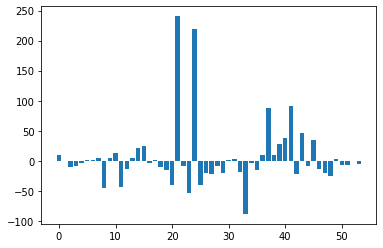

In [22]:
#from matplotlib import pyplot

# Intercept for linear Regression
print('intercept: ', lm.intercept_)

# Coefficients / Feature Importance
coefficients = lm.coef_

# summarize feature importance
for i,v in enumerate(coefficients):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
# plot feature importance
pyplot.bar([x for x in range(len(coefficients))], coefficients)
pyplot.show()

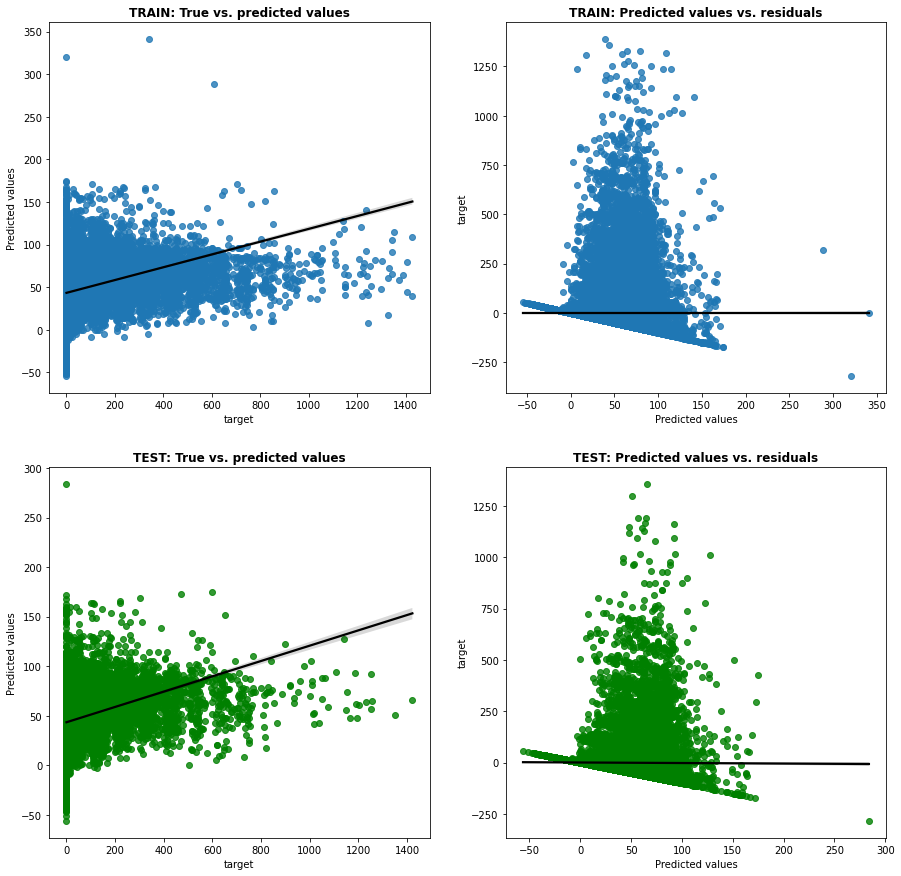

In [23]:
# Error/residual plots for Train and Test data

error_plot(y_train, y_train_lm_pred, y_test, y_test_lm_pred);

### Random Forest Regressor

In [24]:
# from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=RSEED)

# Fit model to training data
rf.fit(X_train, y_train)

# Make predictions on train set
y_train_rf_pred = rf.predict(X_train_scaled)

# Make predictions on test set
y_test_rf_pred = rf.predict(X_test)

In [25]:
# Evaluation Metrics

eval_metrics(y_train, y_train_rf_pred, y_test, y_test_rf_pred)

Training Evaluation Metrics
Mean_Absolute_error (MAE):  64.47792594230955
Mean_square_error (MSE):  18216.430619077597
Root_Mean_square_error (RMSE) :  134.96825782041344
R2_error (R2) :  -0.8648009078258387

---------------
Test Evaluation Metrics
Mean_Absolute_error (MAE):  48.42225154648692
Mean_square_error (MSE):  8925.860050349607
Root_Mean_square_error (RMSE) :  94.47676989794691
R2_error (R2) :  0.0344860088590524


Feature: 0, Score: 0.09008
Feature: 1, Score: 0.30090
Feature: 2, Score: 0.02998
Feature: 3, Score: 0.02883
Feature: 4, Score: 0.03442
Feature: 5, Score: 0.03439
Feature: 6, Score: 0.03785
Feature: 7, Score: 0.03863
Feature: 8, Score: 0.00042
Feature: 9, Score: 0.00234
Feature: 10, Score: 0.00156
Feature: 11, Score: 0.07189
Feature: 12, Score: 0.00876
Feature: 13, Score: 0.00834
Feature: 14, Score: 0.01122
Feature: 15, Score: 0.02904
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00096
Feature: 21, Score: 0.00023
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00001
Feature: 24, Score: 0.00072
Feature: 25, Score: 0.00008
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00382
Feature: 30, Score: 0.00340
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00829
Feature: 35, Score: 0.01347
Fe

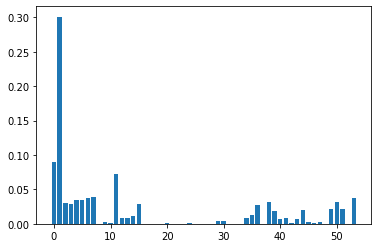

In [26]:
# Feature Importance
#from matplotlib import pyplot

importance_rf = rf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_rf):
	print('Feature: %0d, Score: %.5f' % (i,v))
	
# plot feature importance
pyplot.bar([x for x in range(len(importance_rf))], importance_rf)
pyplot.show()

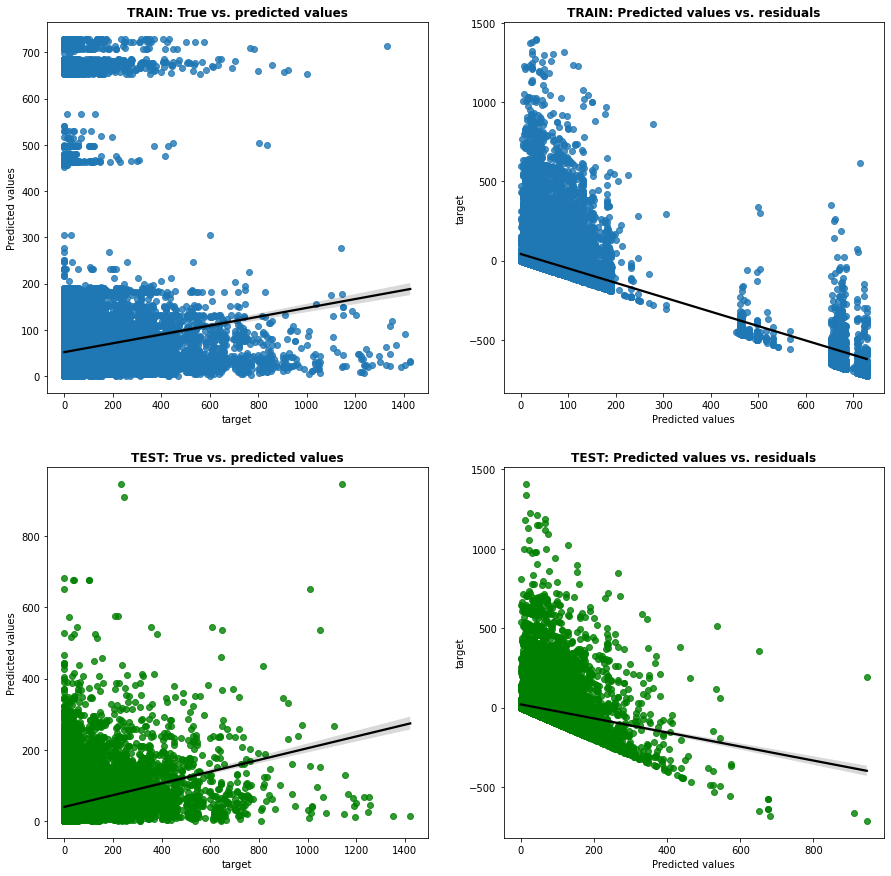

In [27]:
# Error/residual plots

error_plot(y_train, y_train_rf_pred, y_test, y_test_rf_pred);

### Random Forest Regressor K-Fold cross validation

Scores for each fold are: [ -9463.47460662  -9660.39108982 -10162.84010091  -9850.56165536
  -9984.45043788]
------------------------------
Score (scaled): -9824.3436
------------------------------


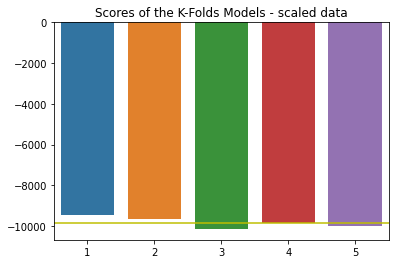

In [28]:
#from sklearn.model_selection import cross_val_score
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data

ra_f = RandomForestRegressor(random_state=RSEED)

scores = cross_val_score(ra_f, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Evaluation
print(f'Scores for each fold are: {scores}')

print('---'*10)
print('Score (scaled):', round(scores.mean(), 4))
print('---'*10)

# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4,5],y=scores).set_title('Scores of the K-Folds Models - scaled data');

### Random Forest Regressor Hyperparameter Tuning

#### Grid Search Cross Validation

In [29]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from timeit import default_timer as timer

#ra_f.get_params().keys()

# Defining parameter grid (as dictionary)

param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'min_samples_leaf': [1, 5, 10],
            'max_depth': [3, 5, 7, 9],
            'max_features': ['auto', 'sqrt'],
            'bootstrap': [True, False]}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(RandomForestRegressor(random_state=RSEED), param_grid, scoring='neg_mean_squared_error',
                  cv=5, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train, y_train)
end = timer()
gs_time = end-start

In [30]:
# Print the time spend and number of models ran
print("GridSearchCV took %.2f seconds for %d candidate parameter settings.", (gs_time - start))

GridSearchCV took %.2f seconds for %d candidate parameter settings. 1138.292353293


In [31]:
# Predict on train and test

y_train_pred_gs = gs.predict(X_train)
y_test_pred_gs = gs.predict(X_test)

In [32]:
# Evaluation Metrics

eval_metrics(y_train, y_train_pred_gs, y_test, y_test_pred_gs)

Training Evaluation Metrics
Mean_Absolute_error (MAE):  48.34945505841528
Mean_square_error (MSE):  8702.890724931114
Root_Mean_square_error (RMSE) :  93.28928515607306
R2_error (R2) :  0.1090922879499655

---------------
Test Evaluation Metrics
Mean_Absolute_error (MAE):  48.284560381286845
Mean_square_error (MSE):  8358.659462813092
Root_Mean_square_error (RMSE) :  91.42570460659897
R2_error (R2) :  0.0958403321355441


In [33]:
#print(gs.cv_results_)

print(gs.best_estimator_)

print(gs.best_params_)

#print(gs.best_score_)

RandomForestRegressor(max_depth=9, min_samples_leaf=10, n_estimators=300,
                      random_state=10)
{'bootstrap': True, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 300}


(<AxesSubplot:title={'center':'TRAIN: True vs. predicted values'}, xlabel='target', ylabel='Predicted values'>,
 <AxesSubplot:title={'center':'TRAIN: Predicted values vs. residuals'}, xlabel='Predicted values', ylabel='target'>,
 <AxesSubplot:title={'center':'TEST: True vs. predicted values'}, xlabel='target', ylabel='Predicted values'>,
 <AxesSubplot:title={'center':'TEST: Predicted values vs. residuals'}, xlabel='Predicted values', ylabel='target'>)

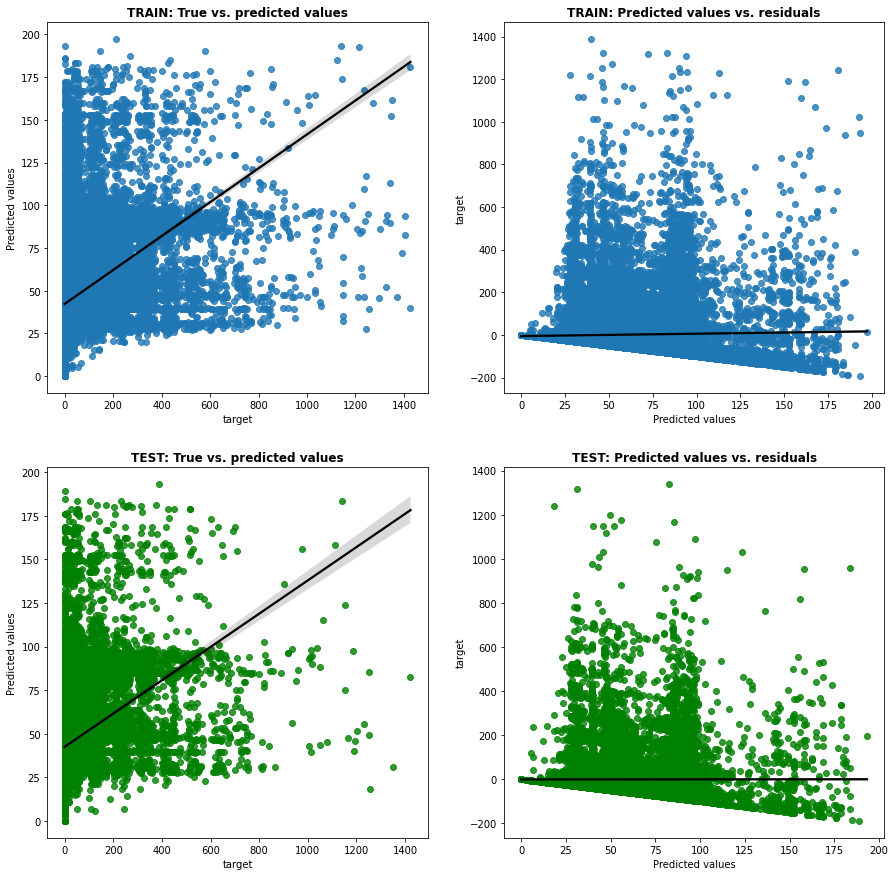

In [34]:
# Error /residual plots for Training and Test data

error_plot(y_train, y_train_pred_gs, y_test, y_test_pred_gs)

### XGBoost Regression

In [35]:
#from xgboost import XGBRegressor
xgb = XGBRegressor()

#fit model
xgb.fit(X_train, y_train)

# make a prediction for training and test data
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

In [36]:
# Evaluation Metrics

eval_metrics(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)

Training Evaluation Metrics
Mean_Absolute_error (MAE):  46.16235586802027
Mean_square_error (MSE):  7940.234397621127
Root_Mean_square_error (RMSE) :  89.10799289413451
R2_error (R2) :  0.18716478421810656

---------------
Test Evaluation Metrics
Mean_Absolute_error (MAE):  47.62287108580798
Mean_square_error (MSE):  8275.768070489818
Root_Mean_square_error (RMSE) :  90.97124859256257
R2_error (R2) :  0.10480672849195327


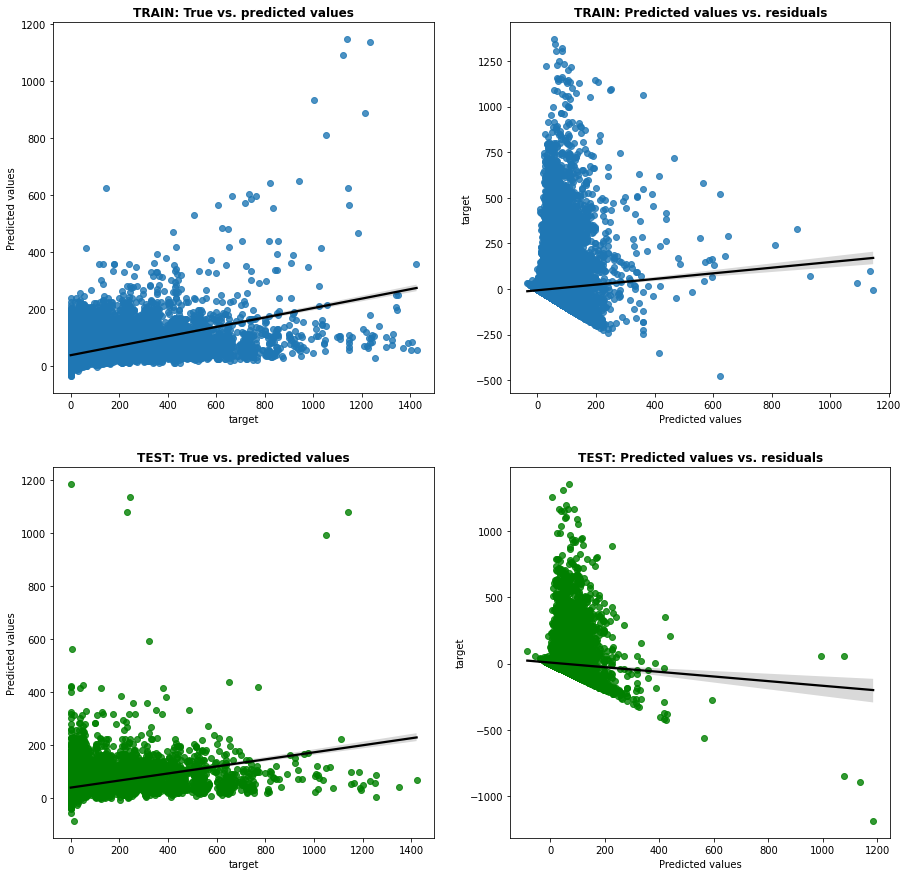

In [37]:
# Error /residual plots for Training and Test data

error_plot(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb);

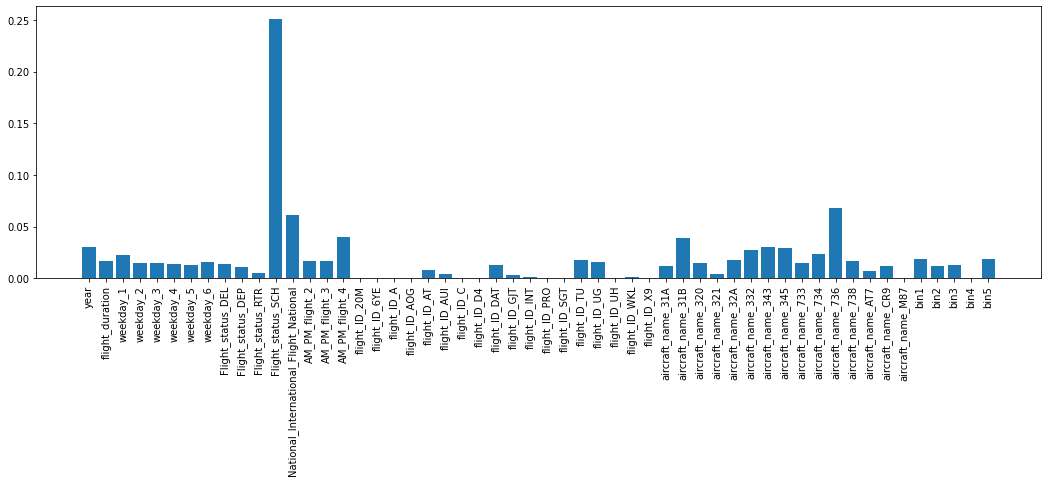

In [38]:
# Feature Importance Method-1

plt.figure(figsize=(18,5))
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.xticks(range(len(xgb.feature_importances_)), X_train.columns)
plt.xticks(rotation=90)
plt.show()

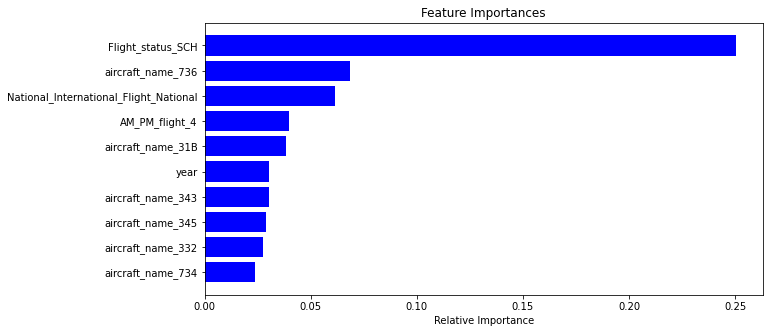

In [39]:
# Feature Importance Method-2

features = X_train.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(10,5))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost Regression Hyperparameter Tunning

In [ ]:

param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

# Instantiate gridsearch and define the metric to optimize 
xgb_gs = GridSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_squared_error',
                  cv=5, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
xgb_gs.fit(X_train, y_train)
end = timer()
gs_time = end-start

In [ ]:
# Predict on train and test

y_train_pred_xgb_gs = xgb_gs.predict(X_train)
y_test_pred_xgb_gs = xgb_gs.predict(X_test)

# Evaluation Metrics
print('---'*5)
print(eval_metrics(y_train, y_train_pred_xgb_gs, y_test, y_test_pred_xgb_gs))

print('---'*5)
print(xgb_gs.best_estimator_)
print(xgb.gs.best_params_)